In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
file = files.upload()

Saving churn_data.csv to churn_data.csv


In [3]:
df = pd.read_csv("churn_data.csv")
df.head(7)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить.

Посмотрим на распределение классов:

In [4]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [6]:
X_train.shape

(7500, 14)

In [7]:
y_train.shape

(7500,)

In [8]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [9]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


### Списки признаков

In [10]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [11]:
#на примере отдельного категориального признака - Gender

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


### пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

tenure =  Pipeline([
                ('selector', NumberSelector(key='Tenure')),
                ('standard', StandardScaler()),
                
            ])

tenure.fit(X_train)
#tenure.transform(X_test).head(3)

Pipeline(memory=None,
         steps=[('selector', NumberSelector(key='Tenure')),
                ('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

### под каждый признак создать трансформер и объединить их в список

In [13]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [14]:
final_transformers

[('Geography', Pipeline(memory=None,
           steps=[('selector', FeatureSelector(column='Geography')),
                  ('ohe', OHEEncoder(key='Geography'))],
           verbose=False)), ('Gender', Pipeline(memory=None,
           steps=[('selector', FeatureSelector(column='Gender')),
                  ('ohe', OHEEncoder(key='Gender'))],
           verbose=False)), ('Tenure', Pipeline(memory=None,
           steps=[('selector', FeatureSelector(column='Tenure')),
                  ('ohe', OHEEncoder(key='Tenure'))],
           verbose=False)), ('HasCrCard', Pipeline(memory=None,
           steps=[('selector', FeatureSelector(column='HasCrCard')),
                  ('ohe', OHEEncoder(key='HasCrCard'))],
           verbose=False)), ('IsActiveMember', Pipeline(memory=None,
           steps=[('selector', FeatureSelector(column='IsActiveMember')),
                  ('ohe', OHEEncoder(key='IsActiveMember'))],
           verbose=False)), ('CreditScore',
  Pipeline(memory=None, steps=[('sel

### все это в единый пайплайн

In [15]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

### добавление модели

In [16]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

### обучение модели

In [17]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [18]:
#прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

### Подобраем порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [20]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


###Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности?
2. Можно ли подобрать порог так, что recall будет равен 1?Что при этом будет с precision
3. Аналогичный вопрос про precision

Чем выше точность, тем меньше единиц противоположного класса определяется как тот, который мы хотим определить. Чем выше полнота, тем больше мы собираем единиц нужного класса. При понижении порога увеличивается полнота, но при этом также увеличивается количество единиц противоположного класса, классфицированных неправильно. Соответственно точность уменьшается. При recall = 1 precision будет минимальна. И наоборот - recall минимальна при precision = 1.

### матрица ошибок

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


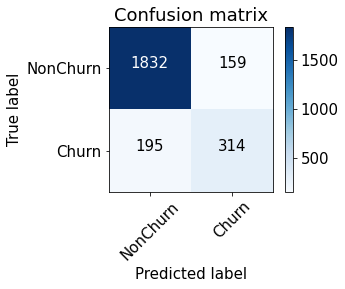

In [22]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми.

### Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?

Получается,что траты на удержание (303 + 159)х1 = 462, а 
прибыль с правильно классифицированного 314х2 = 628, следовательно 
итоговая прибыль 166

##  **Для нашего пайплайна поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков**

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

In [24]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


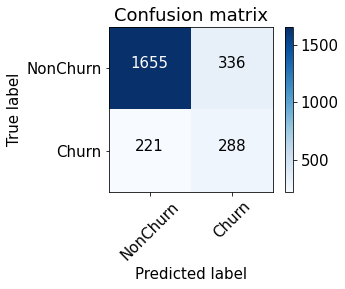

In [26]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [27]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


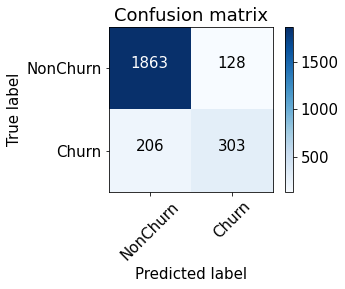

In [29]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### **Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)**

GradientBoostingClassifier. Для случая с 1 и 2 долларами выгоднее точность для минимизации трат.

### **Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.**

траты на удержание (303 + 128)х1 = 431
прибыль с правильно классифицированного 303х2 = 606
итоговая прибыль 175

### **(опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3**

In [30]:
from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], 'n_estimators': [50, 100, 150],
              'min_samples_leaf':[1, 2, 5], 'max_depth':[2, 3, 4]}

gb = GradientBoostingClassifier(random_state = 42)
gs = GridSearchCV(gb, parameters)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', gs),
])

pipeline.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'learning_rate': 0.2,
  'max_depth': 3,
  'min_samples_leaf': 2,
  'n_estimators': 100},
 0.8652)

In [31]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.2, random_state = 42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


Best Threshold=0.372968, F-Score=0.644, Precision=0.658, Recall=0.631


Confusion matrix, without normalization
[[1824  167]
 [ 189  320]]


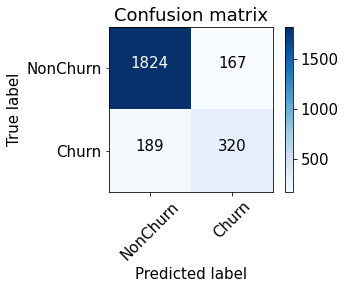

In [32]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### **(опционально) Еще раз провести оценку экономической эффективности**

траты на удержание (320 + 167)х1 = 487
прибыль с правильно классифицированного 320х2 = 640
итоговая прибыль 153

Выросла полнота, но упала точность, так как порог понизился. F-мера немного понизилась.